# ROI Decoding

### Goals of this script

Classifier analysis for STCBPE, heavily based on previous code from Elizabeth McDevitt

1. import labels (already trimmed)
2. shift labels to account for hemodynamic lag
3. load BOLD data and apply masks
4. save the voxel x TR matrix
5. reshape data (remove all fixation timepoints)
6. run a classifier
    includes four 2-way classifiers, without resting data mixed in
7. classify out of sample data from the listening phase of the experiment
8. signal detection against ground truth labels
9. profit?


## Import necessary packages

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
from mpi4py import MPI
import os
import pickle 
import time
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from brainiak.searchlight.searchlight import Searchlight
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns

# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

import pandas as pd

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


## Load settings

In [2]:
sub = 'sub-000'

# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
import sys
sys.path.insert(0, 'jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/code/notebooks')
import svd_utils

from svd_utils import load_stcbpe_localizer_stim_labels, load_svd_mask, load_svd_epi_data, shift_timing, label2TR, mask_data

# load some constants
#from svd_utils import svd_data_dir, svd_bids_dir, svd_all_ROIs, svd_label_dict, svd_n_runs, svd_TR, svd_hrf_lag, svd_TRs_run
from svd_utils import svd_bids_dir, svd_all_ROIs, svd_label_dict, n_runs, svd_TR, svd_hrf_lag, TRs_run

n_trunc=2 # Number of volumes to trim/truncate
shift_size = int(svd_hrf_lag / svd_TR) # Convert the shift into TRs
#TRs_run = TRs_run-n_trunc #if data are already trimmed, update TRs_run

bold_dir=svd_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub
anat_dir=svd_bids_dir + 'derivatives/fmriprep/%s/anat/' % sub
my_fold= svd_bids_dir + 'derivatives/firstlevel/%s/ses-01/' % sub
my_fold_s2 = svd_bids_dir + 'derivatives/firstlevel/%s/ses-02/' % sub
regressor_dir = svd_bids_dir + 'code/sub_level/glm/regressors/'

# ROIs=['bilateral_PPA_cluster','bilateral_oc-temp','ses-01_brain']
ROIs=['bilateral_PPA_cluster','bilateral_oc-temp']
roi_abbreviations = ['ppa','octemp']

print('bids dir = %s' % (svd_bids_dir))
print('')
print('subject dir = %s' % (bold_dir))
print('')
print('output dir = %s' % (my_fold))
print('')
# print('ROIs = %s' % (ROIs))
# print('Labels = %s' % (svd_label_dict))
# print('number of runs = %d' % (svd_n_runs))
# print('TR = %s seconds' % (svd_TR))
# print('%d volumes trimmed from each run' % (n_trunc))
# print('TRs per run after trimming = %s' % (svd_TRs_run))


bids dir = /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/

subject dir = /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/fmriprep/sub-000/ses-01/func/

output dir = /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/ses-01/



## Stimulus labels  - load truncated stimulus labels and shift labels 4.5 sec (3 TRs)

[[  0   0   0   0   0   2   2   2   2   2   2   2   2   2   2   2   0   0
    0   0   0   0   0   0   0   3   3   3   3   3   3   3   3   3   3   3
    0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1
    1   1   0   0   0   0   0   0   0   0   0   4   4   4   4   4   4   4
    4   4   4   4   0   0   0   0   0   0   0   0   0   2   2   2   2   2
    2   2   2   2   2   2   0   0   0   0   0   0   0   0   0   4   4   4
    4   4   4   4   4   4   4   4   0   0   0   0   0   0   0   0   0   3
    3   3   3   3   3   3   3   3   3   3   0   0   0   0   0   0   0   0
    0   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0   0   0
    0   0   0   3   3   3   3   3   3   3   3   3   3   3   0   0   0   0
    0   0   0   0   0   4   4   4   4   4   4   4   4   4   4   4   0   0
    0   0   0   0   0   0   0   2   2   2   2   2   2   2   2   2   2   2
    0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1
    1   1   0   0   0   0   0   0   0 

Text(0.5,0,'TR')

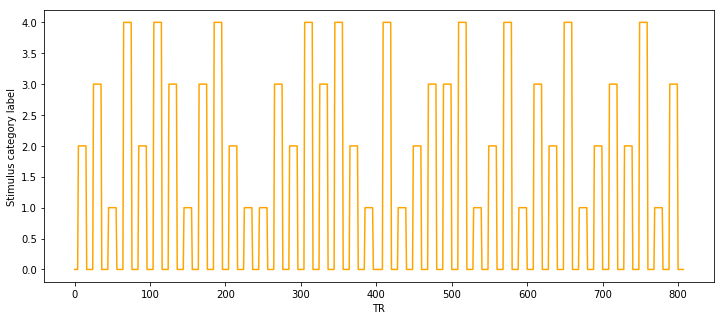

In [3]:
# load stimulus labels from regressor file for each run and concatenate
# NOTE: Regressor files are already trimmed (but not shifted) in Matlab using gen_loc_regressor_0101.m

stim_label_allruns = load_stcbpe_localizer_stim_labels(sub) # this function takes individual run regressor files and concatenates them
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))
print('')
print('Trimmed (but not shifted) labels should have 5 leading zeros and 8 trailing zeros')
print(stim_label_allruns[0,:])

# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label_allruns[0,:], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')


shift by 3 TRs
stim_label_allruns has shape:  (2, 808)
stim_label_allruns_shifted has shape:  (2, 808)

Trimmed AND shifted labels should have 10 leading zeros and 9 trailing zeros
[0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 

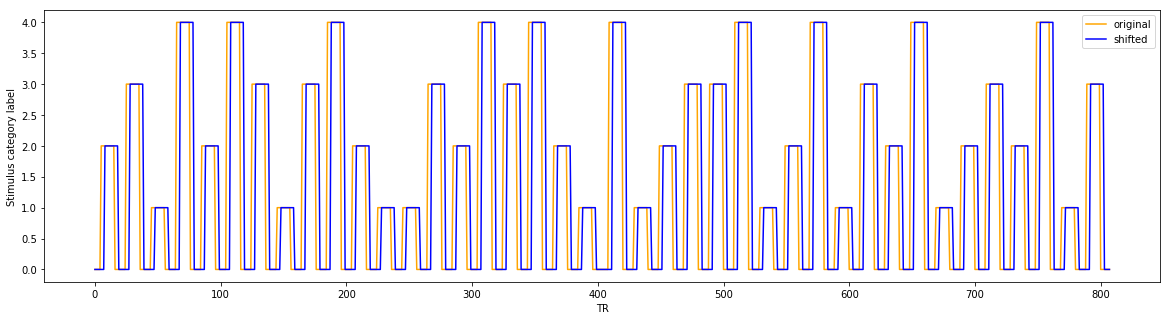

In [4]:
# Shift the data labels to account for hemodynamic lag
shift_size = int(svd_hrf_lag / svd_TR)  # Convert the shift into TRs
print('shift by %s TRs' % (shift_size))

# Be careful, these values are hardcoded for now...
zero_shift = np.zeros((stim_label_allruns.shape[0],shift_size))
end_trim = stim_label_allruns.shape[1]-shift_size

# insert shift columns at beginning and trim columns at end
stim_label_allruns_shifted = np.hstack((zero_shift,stim_label_allruns[:,0:end_trim])) 

# stim_label_allruns_shifted = shift_timing(stim_label_allruns[0,:], shift_size)
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))
print('stim_label_allruns_shifted has shape: ', np.shape(stim_label_allruns_shifted))
print('')
print('Trimmed AND shifted labels should have 10 leading zeros and 9 trailing zeros')
print(stim_label_allruns_shifted[0,:])

# Plot the original and shifted labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label_allruns[0,:], label='original', c='orange')
ax.plot(stim_label_allruns_shifted[0,:], label='shifted', c='blue')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

# # Trimmed AND shifted labels should have 10 leading zeros and 9 trailing zeros

## Load fMRI data and apply masks

In [5]:
mask_list = ROIs
print('use these ROIs: ', mask_list)

# load defaced T1 image (merged T1 from fmriprep)
from nilearn.plotting import plot_roi
t1_file = anat_dir + sub + '_desc-preproc_T1w.nii.gz'
t1_img = image.load_img(t1_file) 

# load fMRI data
### previous code didn't load trimmed and normalized epi, check with lizzie if changing this was the right move
epi_in = (my_fold + "%s_ses-01_task-localizer_run-all_space-T1w_desc-preproc_bold_trim9and5TRs_normalized.nii.gz" % (sub))
epi_data = nib.load(epi_in)
print("Loading data from %s" % (epi_in))
print('epi_data shape: ', epi_data.shape)

use these ROIs:  ['bilateral_PPA_cluster', 'bilateral_oc-temp']
Loading data from /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/ses-01/sub-000_ses-01_task-localizer_run-all_space-T1w_desc-preproc_bold_trim9and5TRs_normalized.nii.gz
epi_data shape:  (66, 86, 70, 808)


Loaded bilateral_PPA_cluster mask
voxel by TR matrix - shape:  (461, 808)

Loaded bilateral_oc-temp mask
voxel by TR matrix - shape:  (2622, 808)



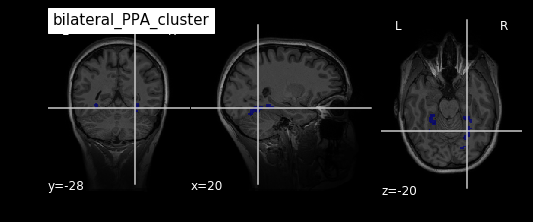

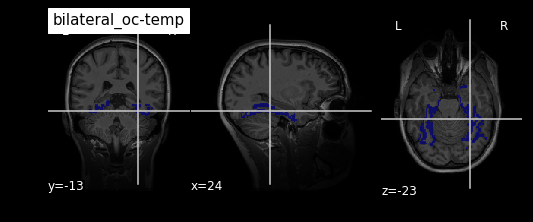

In [6]:
masked_data = [];

# Make a function to load the mask data
def load_svd_masked_data(directory, subject_name, mask_list):
    masked_data_all = [0] * len(mask_list)

    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        # load the mask for the corresponding ROI
        this_mask = mask_list[mask_counter]
        mask = load_svd_mask(mask_list[mask_counter], subject_name)
        
        # plot mask overlayed on subject's T1
        plot_roi(mask, bg_img=t1_img, title=this_mask)
        
        # mask the data 
        epi_masked_data = mask_data(epi_data, mask)
        epi_masked_data = np.transpose(epi_masked_data)
        
        # Check the dimensionality of the data
        print('voxel by TR matrix - shape: ', epi_masked_data.shape)
        print('')
        
        masked_data_all[mask_counter] = epi_masked_data
        
    return masked_data_all

# Apply function
masked_data_all = load_svd_masked_data(my_fold, sub, ROIs)

### Save voxel x TR matrix:

In [7]:
for mask_counter in range(len(mask_list)):
        this_mask = mask_list[mask_counter]
        mat_out = svd_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data/%s_ses-01_task-localizer_run-all_space-T1w_mask-%s' % (sub, sub, this_mask)
        print('saving to file: ', mat_out)
        print('')
        scipy.io.savemat(mat_out, mdict={'data': masked_data_all[mask_counter]})

print('Saving complete')

saving to file:  /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/masked_epi_data/sub-000_ses-01_task-localizer_run-all_space-T1w_mask-bilateral_PPA_cluster

saving to file:  /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/masked_epi_data/sub-000_ses-01_task-localizer_run-all_space-T1w_mask-bilateral_oc-temp

Saving complete


## OR if voxel x TR matrix already exists, load matrix:

In [8]:
# # load voxel x TR data for each ROI
# mask_list = ROIs
# masked_data = [];
# masked_data_all = [0] * len(mask_list);

# # load defaced T1 image (merged T1 from fmriprep)
# from nilearn.plotting import plot_roi
# t1_file = anat_dir + sub + '_desc-preproc_T1w_defaced.nii.gz'
# t1_img = image.load_img(t1_file) 

# for mask_counter in range(len(mask_list)):
#     this_mask = mask_list[mask_counter]
    
#     mask = load_svd_mask(mask_list[mask_counter], sub)
#     # plot mask overlayed on subject's T1
#     plot_roi(mask, bg_img=t1_img, title=this_mask)
    
#     in_file = (svd_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data/%s_ses-00_task-localizer_run-all_space-T1w_mask-%s.mat' % (sub, sub, this_mask))
#     # Load in data from matlab
#     masked_data = scipy.io.loadmat(in_file);
#     masked_data = np.array(masked_data['data']);
#     print('mask:', this_mask)
#     print('masked_data shape:', masked_data.shape)
    
#     masked_data_all[mask_counter] = masked_data

In [9]:
# # check dimensionality of the data and plot value of voxel_id across timeseries 
# voxel_id = 200
# for mask_counter in range(len(mask_list)):
#     this_mask = mask_list[mask_counter]
#     print('voxel by TR matrix - shape: ', this_mask, masked_data_all[mask_counter].shape) #ses00brain
    
#     f, ax = plt.subplots(1,1, figsize=(14,5))
#     ax.plot(masked_data_all[mask_counter][voxel_id,:])

#     ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
#     ax.set_xlabel('TR')
#     ax.set_ylabel('Voxel Intensity')
    
# print('label list - shape: ', stim_label_allruns_shifted.shape)

## Reshape data 
Extract the time points for which we have stimulus labels -- i.e., we drop the time-points from the BOLD signal that refer to the fixation period

In [10]:
# remove all zeros and only keep presentation timepoints

print(stim_label_allruns_shifted[0,:])
print(np.shape(stim_label_allruns_shifted[0,:]))

#find_zeros = np.where(stim_label_allruns_shifted[0,:] == 0)[0] #to double check that numbers line up

# # BE CAREFUL, THIS IS HARDCODED FOR NOW...
# label_index_r1 = np.array(range(8,404-5))
# label_index_r2 = np.array(range(412,808-5))
# label_index = np.hstack(range()) 
#print(label_index)
#print(np.shape(label_index))

label_index = np.nonzero(stim_label_allruns_shifted[0,:])
label_index = np.squeeze(label_index)
print(label_index)

reshaped_labels = stim_label_allruns_shifted[:,label_index] #this pulls out columns associated with non-zero labels in the labels file
print(reshaped_labels[0,:])
print(np.shape(reshaped_labels[0,:]))

# Remove beginning and end fixation period volumes from bold data
print('mask list:', mask_list)
bold_data_reshaped = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
        this_mask = mask_list[mask_counter]
        print(this_mask)
        
        # Pull out the indexes
        indexed_data = masked_data_all[mask_counter][:,label_index] #this pulls out columns associated with non-zero labels in the epi data
    
        print('Original epi shape:', masked_data_all[mask_counter].shape)
        print('epi shape after removing zeros:', indexed_data.shape) #this is the bold data with zeros removed

        # transpose bold data to make it timepoints x n_voxels
        bold_data = np.transpose(indexed_data)
        print('timepoints x n_voxels (bold_data):', bold_data.shape)
        print('')

        bold_data_reshaped[mask_counter] = bold_data

[0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.

labels: 440
(440,)


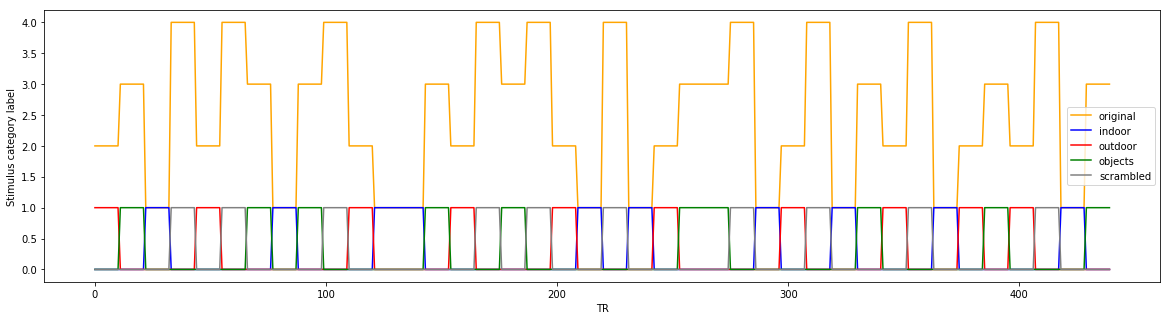

In [11]:
# Create 4 sets of labels: indoor vs. others, outdoor vs. others, objects vs. non-objects, scrambled vs. non-scrambled

labels = reshaped_labels[0,:]
print('labels:', labels.size)
# print(labels)
print(labels.shape)

# indoor
def numberfunc(x):
    if x == 1:
        return 1
    else:
        return 0

labels_indoor = np.array(list(map(numberfunc, labels[:,])))

# outdoor
def numberfunc(x):
    if x == 2:
        return 1
    else:
        return 0

labels_outdoor = np.array(list(map(numberfunc, labels[:,])))

# objects
def numberfunc(x):
    if x == 3:
        return 1
    else:
        return 0

labels_objects = np.array(list(map(numberfunc, labels[:,])))

# scrambled
def numberfunc(x):
    if x == 4:
        return 1
    else:
        return 0

labels_scrambled = np.array(list(map(numberfunc, labels[:,])))

# Plot the original and modified labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(labels, label='original', c='orange')
ax.plot(labels_indoor, label='indoor', c='blue')
ax.plot(labels_outdoor, label='outdoor', c='red')
ax.plot(labels_objects, label='objects', c='green')
ax.plot(labels_scrambled, label='scrambled', c='gray')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

# Step 2. Training classifiers with preselected params on all localizer data

In [12]:
svcs_indoor = [0] * len(mask_list)
svcs_outdoor = [0] * len(mask_list)
svcs_objects = [0] * len(mask_list)
svcs_scrambled = [0] * len(mask_list)

lgrs_indoor = [0] * len(mask_list)
lgrs_outdoor = [0] * len(mask_list)
lgrs_objects = [0] * len(mask_list)
lgrs_scrambled = [0] * len(mask_list)

# can be modified to directly read params from csv
sub_specific_svc_params = {'C': 6.0, 'gamma': 0.001, 'kernel': 'rbf', 'class_weight': 'balanced','probability':True}

for mask_counter in range(len(mask_list)):
    # train indoor vs all 
    svcs_indoor[mask_counter] = SVC(**sub_specific_svc_params)
    svcs_indoor[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_indoor)
    # train outdoor vs all
    svcs_outdoor[mask_counter] = SVC(**sub_specific_svc_params)
    svcs_outdoor[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_outdoor)
    # train objects vs all
    svcs_objects[mask_counter] = SVC(**sub_specific_svc_params)
    svcs_objects[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_objects)
    # train scrambled vs all
    svcs_scrambled[mask_counter] = SVC(**sub_specific_svc_params)
    svcs_scrambled[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_scrambled)
    
    lgrs_indoor[mask_counter] = LogisticRegression(class_weight = 'balanced')
    lgrs_indoor[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_indoor)
    # train outdoor vs all
    lgrs_outdoor[mask_counter] = LogisticRegression(class_weight = 'balanced')
    lgrs_outdoor[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_outdoor)
    # train objects vs all
    lgrs_objects[mask_counter] = LogisticRegression(class_weight = 'balanced')
    lgrs_objects[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_objects)
    # train scrambled vs all
    lgrs_scrambled[mask_counter] = LogisticRegression(class_weight = 'balanced')
    lgrs_scrambled[mask_counter].fit(X = bold_data_reshaped[mask_counter], y = labels_scrambled)


In [13]:
lgrs_indoor[0]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Step 3. import listening phase data

In [14]:
mask_list = ROIs
print('use these ROIs for listening phase data: ', mask_list)

# load defaced T1 image (merged T1 from fmriprep)
from nilearn.plotting import plot_roi
t1_file = anat_dir + sub + '_desc-preproc_T1w.nii.gz'
t1_img = image.load_img(t1_file) 

# load fMRI data
### previous code didn't load trimmed and normalized epi, check with lizzie if changing this was the right move
epi_in_listen = (my_fold_s2 + "%s_ses-02_task-listening_run-all_space-T1w_desc-preproc_bold_trim9and5TRs_normalized.nii.gz" % (sub))
epi_data_listen = nib.load(epi_in_listen)
print("Loading run 1 listening data from %s" % (epi_in_listen))
print('epi_data shape: ', epi_data_listen.shape)


use these ROIs for listening phase data:  ['bilateral_PPA_cluster', 'bilateral_oc-temp']
Loading run 1 listening data from /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/ses-02/sub-000_ses-02_task-listening_run-all_space-T1w_desc-preproc_bold_trim9and5TRs_normalized.nii.gz
epi_data shape:  (66, 86, 70, 434)


Loaded bilateral_PPA_cluster mask
voxel by TR matrix - shape:  (461, 434)

Loaded bilateral_oc-temp mask
voxel by TR matrix - shape:  (2622, 434)



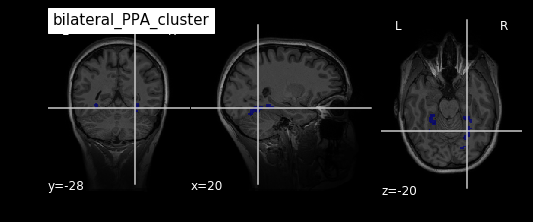

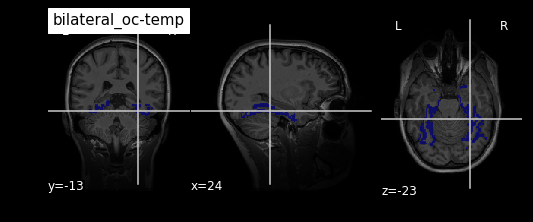

In [15]:
masked_data_listening = [];

# Make a function to load the mask data
# hacky right now but make this more general purpose later by making the epi_data an argument
def load_listening_masked_data(directory, subject_name, mask_list):
    masked_data_all = [0] * len(mask_list)

    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        # load the mask for the corresponding ROI
        this_mask = mask_list[mask_counter]
        mask = load_svd_mask(mask_list[mask_counter], subject_name)
        
        # plot mask overlayed on subject's T1
        plot_roi(mask, bg_img=t1_img, title=this_mask)
        
        # mask the data 
        epi_masked_data = mask_data(epi_data_listen, mask)
        epi_masked_data = np.transpose(epi_masked_data)
        
        # Check the dimensionality of the data
        print('voxel by TR matrix - shape: ', epi_masked_data.shape)
        print('')
        
        masked_data_all[mask_counter] = epi_masked_data
        
    return masked_data_all

# Apply function
masked_data_listening = load_listening_masked_data(my_fold_s2, sub, ROIs)

# transposing for classification
reshaped_data_listening = [0] * len(mask_list)
for mask_counter in range(len(mask_list)):
    reshaped_data_listening[mask_counter] = np.transpose(masked_data_listening[mask_counter])

### Save voxel x TR matrix:

In [16]:
for mask_counter in range(len(mask_list)):
        this_mask = mask_list[mask_counter]
        mat_out = svd_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data/%s_ses-02_task-listening_run-all_space-T1w_mask-%s' % (sub, sub, this_mask)
        print('saving to file: ', mat_out)
        print('')
        scipy.io.savemat(mat_out, mdict={'data': masked_data_listening[mask_counter]})

print('Saving complete')

saving to file:  /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/masked_epi_data/sub-000_ses-02_task-listening_run-all_space-T1w_mask-bilateral_PPA_cluster

saving to file:  /jukebox/tamir/zidong/stcbpe/pyger_pipe/bids/TamirL/Zhao/STCBPE/derivatives/firstlevel/sub-000/masked_epi_data/sub-000_ses-02_task-listening_run-all_space-T1w_mask-bilateral_oc-temp

Saving complete


# Step 4. Getting predicted proba for each TR

In [17]:
pred_proba_indoor = [0] * len(mask_list)
pred_proba_outdoor = [0] * len(mask_list)
pred_proba_objects = [0] * len(mask_list)
pred_proba_scrambled = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
    # train indoor vs all 
    pred_proba_indoor[mask_counter] = lgrs_indoor[mask_counter].predict_proba(X = reshaped_data_listening[mask_counter])
    # train outdoor vs all
    pred_proba_outdoor[mask_counter] = lgrs_outdoor[mask_counter].predict_proba(X = reshaped_data_listening[mask_counter])
    # train objects vs all
    pred_proba_objects[mask_counter] = lgrs_objects[mask_counter].predict_proba(X = reshaped_data_listening[mask_counter])
    # train scrambled vs all
    pred_proba_scrambled[mask_counter] = lgrs_scrambled[mask_counter].predict_proba(X = reshaped_data_listening[mask_counter])

In [18]:
## take the abnormally large values out for plotting purposes
for mask_counter in range(len(mask_list)):
    # train indoor vs all 
    pred_proba_indoor[mask_counter][pred_proba_indoor[mask_counter] > .6] = 0
    # train outdoor vs all
    pred_proba_outdoor[mask_counter][pred_proba_outdoor[mask_counter] > .6] = 0
    # train objects vs all
    pred_proba_objects[mask_counter][pred_proba_objects[mask_counter] > .6] = 0
    # train scrambled vs all
    pred_proba_scrambled[mask_counter][pred_proba_scrambled[mask_counter] > .6] = 0

In [19]:
# import trial labels, etc
tr_labels_r1 = pd.read_csv(regressor_dir+sub+'_ses-02_task-listening_regressor-shift3TRs-trim9and5TRs_run-01.csv')
tr_labels_r2 = pd.read_csv(regressor_dir+sub+'_ses-02_task-listening_regressor-shift3TRs-trim9and5TRs_run-02.csv')
tr_labels = tr_labels_r1.append(tr_labels_r2)
tr_labels.columns = ['stage', 'trial_type', 'scene_listening','target']
# create a new column that records the originally chosen scene
tr_labels['scene_chosen'] = np.NaN
# direct mirroring for complete repeats
tr_labels['scene_chosen'].loc[tr_labels.trial_type == 'rep'] = \
    tr_labels['scene_listening'].loc[tr_labels.trial_type == 'rep']
# flipping for partial trials
flip_dict = {'outdoor':'indoor','indoor':'outdoor'}
tr_labels['scene_chosen'].loc[tr_labels.trial_type == 'partial'] = \
    [flip_dict[i] for i in tr_labels['scene_listening'].loc[tr_labels.trial_type == 'partial']]
    
tr_labels = tr_labels.fillna('null')

# fill pred proba into this dataframe
category_list = ['indoor','outdoor','objects','scrambled']
for m_counter in np.arange(len(mask_list)):
    for c_counter in np.arange(len(category_list)):
        column_name = roi_abbreviations[m_counter] + '_' + category_list[c_counter]
        pred_proba_name = 'pred_proba_' + category_list[c_counter]
        tr_labels[column_name] = vars()[pred_proba_name][m_counter][:,1]
dftr = tr_labels  

In [20]:
print(dftr.octemp_indoor.loc[(dftr.scene_chosen == 'indoor') & (dftr.stage == 4)].mean())
print(dftr.octemp_indoor.loc[(dftr.scene_chosen == 'outdoor') & (dftr.stage == 4)].mean())
print(dftr.octemp_outdoor.loc[(dftr.scene_chosen == 'indoor') & (dftr.stage == 4)].mean())
print(dftr.octemp_outdoor.loc[(dftr.scene_chosen == 'outdoor') & (dftr.stage == 4)].mean())

0.01753537679093457
0.036396403624763596
0.09626813220554899
0.09150339866382688


In [21]:
dftr.groupby(['scene_chosen', 'stage']).mean()

ppa_indoor  ppa_outdoor  ppa_objects  ppa_scrambled  \
scene_chosen stage                                                        
indoor       1        0.065423     0.069831     0.071599       0.085977   
             2        0.097829     0.036433     0.088182       0.063646   
             3        0.052547     0.086924     0.039892       0.108039   
             4        0.052497     0.108372     0.009716       0.074458   
null         0        0.063007     0.069884     0.061462       0.083169   
outdoor      1        0.027182     0.079284     0.038782       0.059440   
             2        0.052360     0.048392     0.098392       0.100501   
             3        0.079553     0.088134     0.087372       0.130985   
             4        0.075500     0.092114     0.066160       0.037846   

                    octemp_indoor  octemp_outdoor  octemp_objects  \
scene_chosen stage                                                  
indoor       1           0.015675        0.131033        0.033028   
             2           0.129899        0.110769        0.098493   
             3           0.070768        0.098250        0.077886   
             4           0.017535        0.096268        0.081819   
null         0           0.083950        0.105026        0.063242   
outdoor      1           0.084946        0.068761        0.028948   
             2           0.071152        0.132800        0.109314   
             3           0.078140        0.124888        0.107405   
             4           0.036396        0.091503        0.087034   

                    octemp_scrambled  
scene_chosen stage                    
indoor       1              0.084537  
             2              0.071815  
             3              0.152481  
             4              0.090603  
null         0              0.065784  
outdoor      1              0.034091  
             2              0.044555  
             3              0.146216  
             4              0.066884

In [22]:
dftr.groupby(['scene_listening', 'stage']).mean()

ppa_indoor  ppa_outdoor  ppa_objects  ppa_scrambled  \
scene_listening stage                                                        
indoor          1        0.040315     0.058466     0.082642       0.058340   
                2        0.087930     0.039896     0.077283       0.099851   
                3        0.066967     0.070579     0.056391       0.089450   
                4        0.041076     0.096883     0.016374       0.040537   
null            0        0.063007     0.069884     0.061462       0.083169   
outdoor         1        0.053145     0.092947     0.023817       0.089129   
                2        0.060425     0.045290     0.111577       0.061757   
                3        0.065003     0.106902     0.071907       0.153868   
                4        0.090196     0.104083     0.062582       0.073998   

                       octemp_indoor  octemp_outdoor  octemp_objects  \
scene_listening stage                                                  
indoor          1           0.060172        0.100198        0.035050   
                2           0.085621        0.146335        0.116676   
                3           0.056925        0.142765        0.074413   
                4           0.028695        0.060043        0.108972   
null            0           0.083950        0.105026        0.063242   
outdoor         1           0.039041        0.099554        0.026346   
                2           0.117559        0.093726        0.089307   
                3           0.094487        0.075917        0.113483   
                4           0.024990        0.132564        0.056375   

                       octemp_scrambled  
scene_listening stage                    
indoor          1              0.083938  
                2              0.035613  
                3              0.096041  
                4              0.055310  
null            0              0.065784  
outdoor         1              0.031172  
                2              0.083982  
                3              0.210271  
                4              0.105525

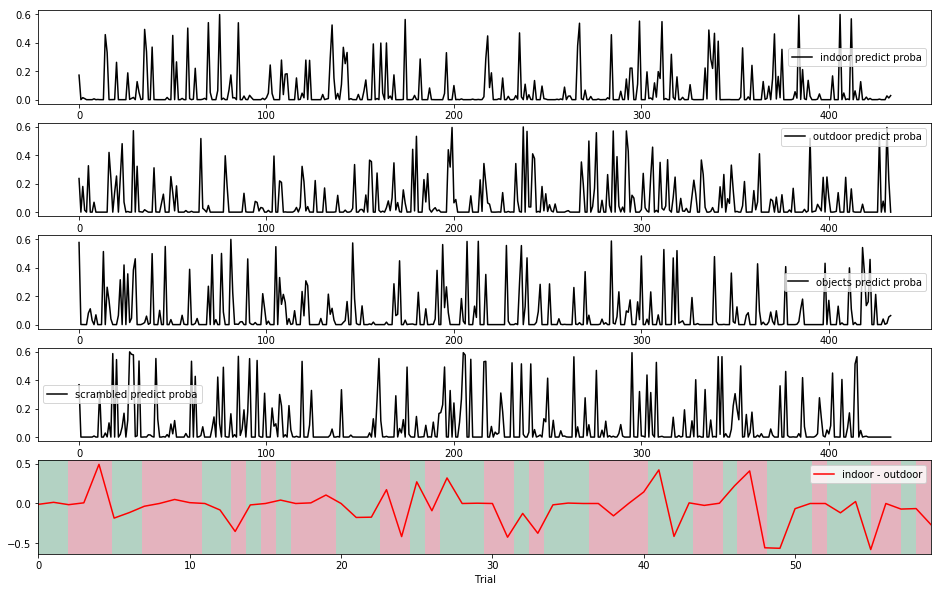

In [23]:
f, ax = plt.subplots(5,1, figsize = (16,10))

ax[0].plot(pred_proba_indoor[0][:,1], label='indoor predict proba', c='black')
ax[0].set_xlabel('Trial')
# ax[0].set_title(title1)
ax[0].legend()

ax[1].plot(pred_proba_outdoor[0][:,1], label='outdoor predict proba', c='black')
ax[1].set_xlabel('Trial')
# ax[1].set_title(title1)
ax[1].legend()

ax[2].plot(pred_proba_objects[1][:,1], label='objects predict proba', c='black')
ax[2].set_xlabel('Trial')
# ax[2].set_title(title1)
ax[2].legend()

ax[3].plot(pred_proba_scrambled[0][:,1], label='scrambled predict proba', c='black')
ax[3].set_xlabel('Trial')
# ax[2].set_title(title1)
ax[3].legend()

ax[4].plot(pred_proba_indoor[0][tr_labels.stage ==3,1]-pred_proba_outdoor[1][tr_labels.stage ==3,1], label='indoor - outdoor', c='red')
ax[4].set_xlabel('Trial')
# ax[2].set_title(title1)
ax[4].legend()
sc_dict = {'indoor':0,'outdoor':1,'null':999}
sc_int = [sc_dict[i] for i in tr_labels['scene_chosen'].loc[tr_labels.stage == 3]]
ax[4].pcolorfast((0,59), ax[4].get_ylim(),
              np.array(sc_int)[:,np.newaxis].transpose(),
              cmap='RdYlGn', alpha=0.3)
# green background is outdoor